In [1]:
!pip install opencv-python-headless numpy matplotlib scipy scikit-image


TypeError: Image data of dtype object cannot be converted to float

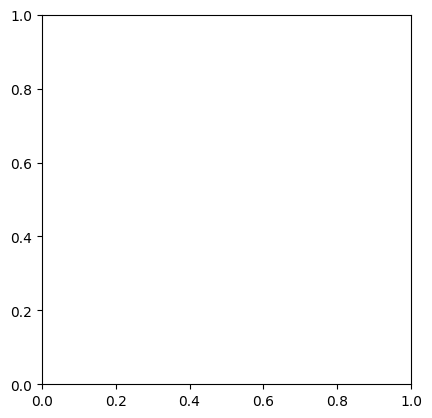

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
import pandas as pd

img = cv2.imread("")
plt.imshow(img)

In [ ]:
# Channel to perform cell count.
cells = img[:,:,0]  # Extract the Blue channel from the image, which is equivalent to a grayscale image.

pixels_to_um = 0.31  # Conversion factor: 1 pixel equals 454 nm (based on metadata from the original image).

# Threshold the image to binary using OTSU's method. All thresholded pixels are set to 255.
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Apply morphological operations (opening) to remove small noise.
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

from skimage.segmentation import clear_border
opening = clear_border(opening)  # Remove objects touching the edges of the image.

# Identify regions that are definitely cells (foreground) and regions that are background.
# Erosion alone may not work due to touching cells, so distance transform will help separate them.

# Define the sure background area by dilating the cells. This expands cell boundaries to include more background.
# The region between sure background and sure foreground is the ambiguous area.
sure_bg = cv2.dilate(opening, kernel, iterations=10)

# Find sure foreground areas using a distance transform and thresholding.
# The intensity of each point represents its distance from the nearest boundary.
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# Threshold the distance transform. Start with half the maximum distance to identify sure foreground regions.
ret2, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

# Adjust the threshold as needed. Lower thresholds like 0.25 may merge cells, while higher thresholds like 0.7 may miss some cells.
# A value around 0.5 is often a good balance.

# Define the unknown region as the difference between sure background and sure foreground.
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Create markers to label connected components. Foreground and background will have positive labels.
# Unknown regions are marked as 0.
ret3, markers = cv2.connectedComponents(sure_fg)

# Adjust background labeling: Add 10 to all labels so the sure background is not labeled as 0.
markers = markers + 10

# Mark the unknown region with 0 for watershed processing.
markers[unknown == 255] = 0

# Apply the watershed algorithm. The boundaries between regions will be marked as -1.
markers = cv2.watershed(img, markers)

# Highlight the boundary regions in yellow.
img[markers == -1] = [0, 255, 255]

# Convert markers to an RGB image for visualization with a background label of 0.
img2 = color.label2rgb(markers, bg_label=0)

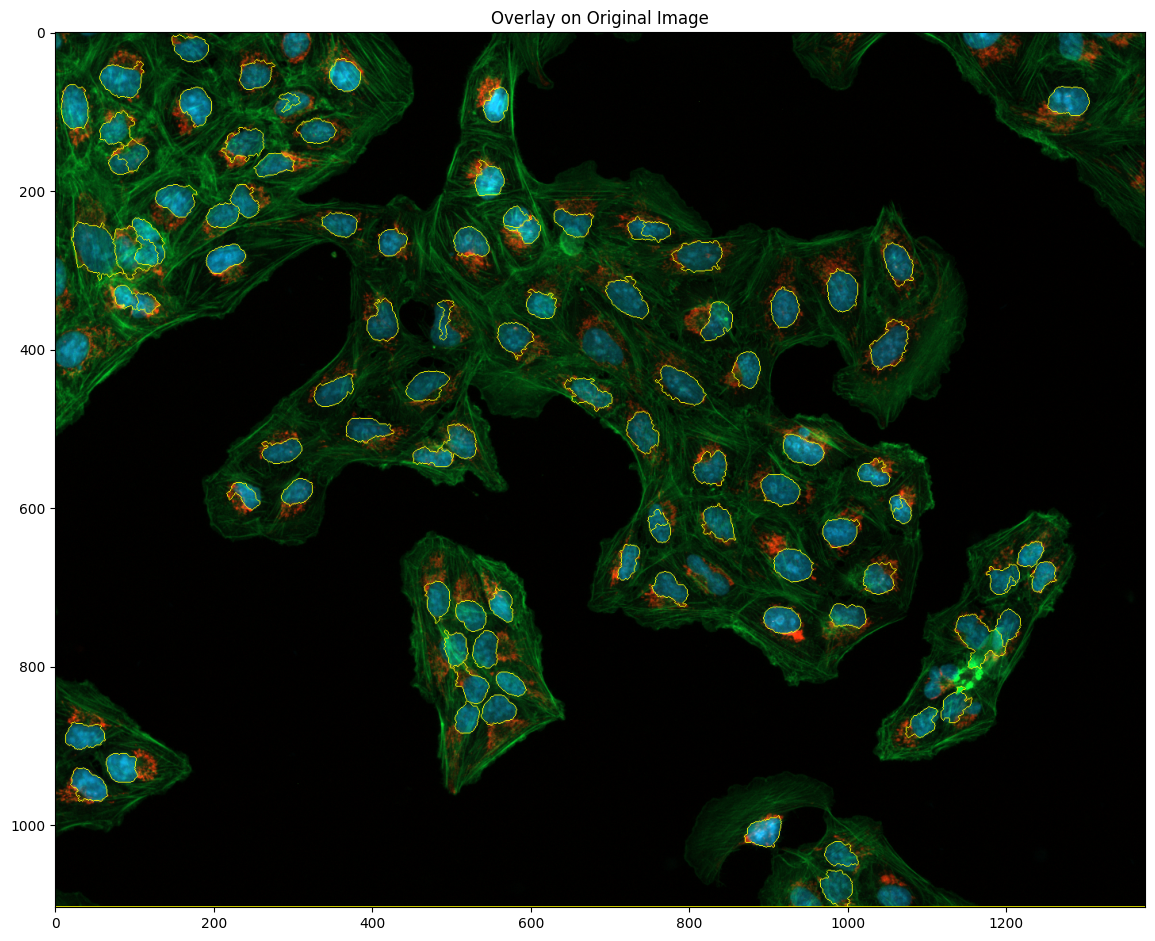

In [ ]:
# Display the results
plt.figure(figsize=(50, 25))
plt.subplot(211), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Overlay on Original Image')
plt.show()

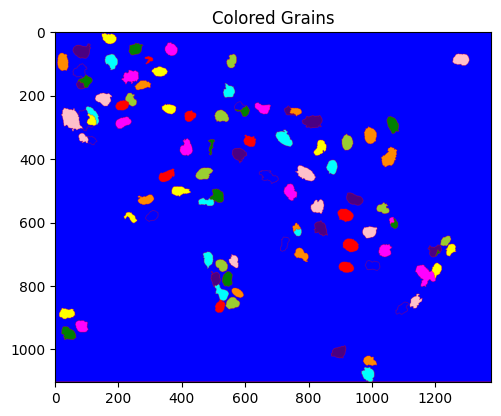

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(212), plt.imshow(img2), plt.title('Colored Grains')
plt.show()

In [ ]:
# Now, time to extract properties of detected cells
# regionprops function in skimage measure module calculates useful parameters for each object.
regions = measure.regionprops(markers, intensity_image=cells)

# Can print various parameters for all objects
for prop in regions:
    print('Label: {} Area: {}'.format(prop.label, prop.area))

# Best way is to output all properties to a csv file
# Let us pick which ones we want to export.

propList = ['Area',
            'equivalent_diameter', # Added... verify if it works
            'orientation', # Added, verify if it works. Angle between x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']

output_data = []
for region_props in regions:
    region_data = [region_props[prop] for prop in propList]
    output_data.append(region_data)

# Convert to DataFrame
df = pd.DataFrame(output_data, columns=propList)

# Save to CSV
df.to_csv('cell_measurements.csv', index=False)

# Display the DataFrame
df.head()

Label: 10 Area: 1400327.0
Label: 11 Area: 1092.0
Label: 12 Area: 1142.0
Label: 13 Area: 1108.0
Label: 14 Area: 1670.0
Label: 15 Area: 1480.0
Label: 16 Area: 1312.0
Label: 17 Area: 1442.0
Label: 18 Area: 940.0
Label: 19 Area: 262.0
Label: 20 Area: 1180.0
Label: 21 Area: 1061.0
Label: 22 Area: 1418.0
Label: 23 Area: 895.0
Label: 24 Area: 399.0
Label: 25 Area: 948.0
Label: 26 Area: 1080.0
Label: 27 Area: 1417.0
Label: 28 Area: 922.0
Label: 29 Area: 941.0
Label: 30 Area: 540.0
Label: 31 Area: 971.0
Label: 32 Area: 1072.0
Label: 33 Area: 643.0
Label: 34 Area: 425.0
Label: 35 Area: 593.0
Label: 36 Area: 844.0
Label: 37 Area: 2838.0
Label: 38 Area: 1212.0
Label: 39 Area: 854.0
Label: 40 Area: 1546.0
Label: 41 Area: 703.0
Label: 42 Area: 1178.0
Label: 43 Area: 1310.0
Label: 44 Area: 1744.0
Label: 45 Area: 1514.0
Label: 46 Area: 1651.0
Label: 47 Area: 587.0
Label: 48 Area: 1277.0
Label: 49 Area: 952.0
Label: 50 Area: 477.0
Label: 51 Area: 1178.0
Label: 52 Area: 1370.0
Label: 53 Area: 406.0
Labe

,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter,MinIntensity,MeanIntensity,MaxIntensity
0,1400327.0,1335.272149,-1.499676,1594.416367,1281.175713,18900.592991,0.0,4.860480,251.0
1,1092.0,37.287767,1.282415,46.559541,30.874839,138.953319,6.0,80.092491,145.0
2,1142.0,38.131871,0.670516,40.901398,35.801276,132.296465,20.0,151.830998,254.0
3,1108.0,37.559944,-1.062275,43.554522,33.119501,146.852814,6.0,78.256318,142.0
4,1670.0,46.111929,1.532047,55.014670,41.705279,188.823376,5.0,106.720359,205.0


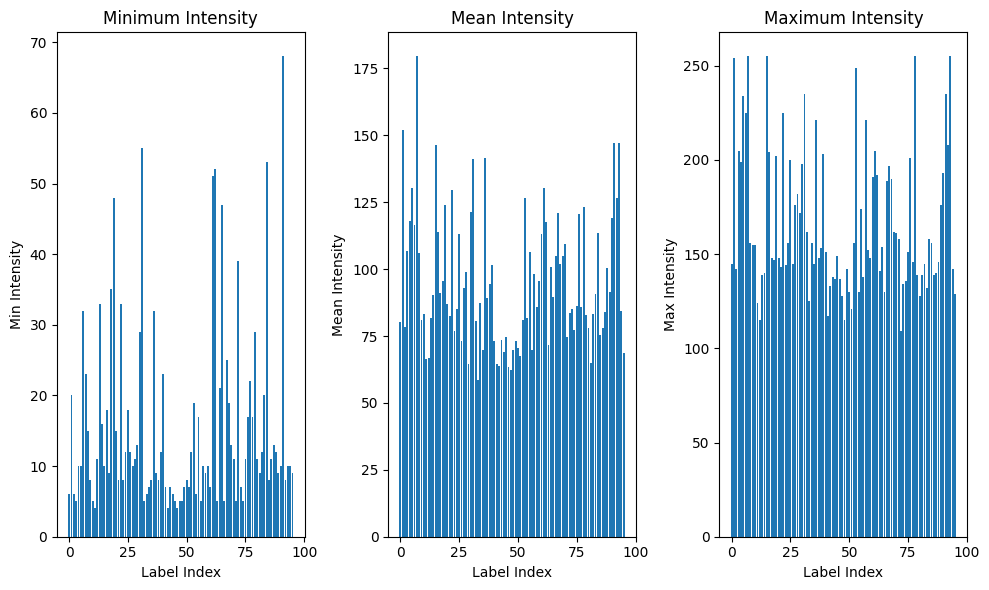

In [ ]:
# prompt: Using dataframe df: intensity graph of all labels bar graph display mean min and max charts differently and in every chart ignore the value of 0th label

import matplotlib.pyplot as plt

# Extract intensity data (excluding the 0th label)
min_intensity = df['MinIntensity'][1:]
mean_intensity = df['MeanIntensity'][1:]
max_intensity = df['MaxIntensity'][1:]

# Create bar graphs
plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.bar(range(len(min_intensity)), min_intensity)
plt.xlabel('Label Index')
plt.ylabel('Min Intensity')
plt.title('Minimum Intensity')

plt.subplot(132)
plt.bar(range(len(mean_intensity)), mean_intensity)
plt.xlabel('Label Index')
plt.ylabel('Mean Intensity')
plt.title('Mean Intensity')

plt.subplot(133)
plt.bar(range(len(max_intensity)), max_intensity)
plt.xlabel('Label Index')
plt.ylabel('Max Intensity')
plt.title('Maximum Intensity')

plt.tight_layout()
plt.show()


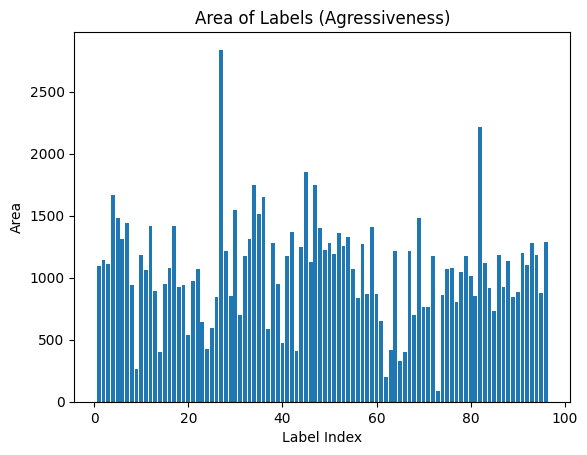

In [ ]:
# prompt: Using dataframe df: bar graph of areas of all labels ignore 0th value

import matplotlib.pyplot as plt
plt.bar(range(1, len(df['Area'])), df['Area'][1:])
plt.xlabel('Label Index')
plt.ylabel('Area')
plt.title('Area of Labels (Agressiveness)')
plt.show()


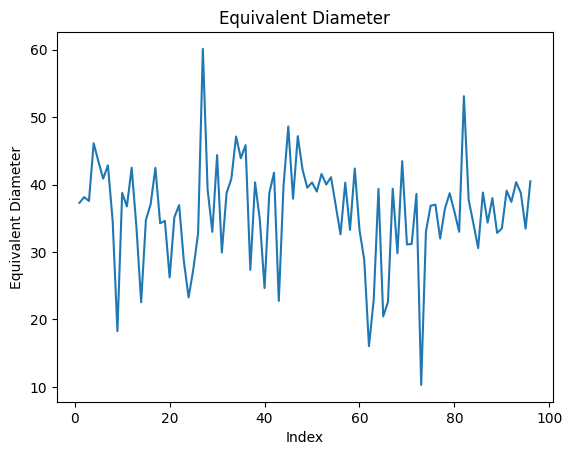

In [ ]:
# prompt: Using dataframe df: equivalent_diameter graph ignore 0th value

import matplotlib.pyplot as plt
plt.plot(df['equivalent_diameter'][1:]) # Plot the 'equivalent_diameter' column, ignoring the first value
plt.xlabel('Index') # Set x-axis label
plt.ylabel('Equivalent Diameter') # Set y-axis label
plt.title('Equivalent Diameter') # Set title
plt.show() # Display the plot
